Imports

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"



Prepare DATASET

In [2]:

train = ImageDataGenerator(rescale=1/255,validation_split=0.2)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory("/Users/nayansavaliya/Masters Mechatronics/2022 Summer/RAML - Project/data/bicubic/train",
                                          target_size=(32,32),
                                          color_mode="grayscale",
                                          batch_size =64,
                                          class_mode = 'binary',
                                          subset='training',)

validation_dataset = train.flow_from_directory("/Users/nayansavaliya/Masters Mechatronics/2022 Summer/RAML - Project/data/bicubic/train",
                                          target_size=(32,32),
                                          color_mode="grayscale",
                                          batch_size = 64,
                                          class_mode = 'binary',
                                          subset='validation')                                    
test_dataset = test.flow_from_directory("/Users/nayansavaliya/Masters Mechatronics/2022 Summer/RAML - Project/data/bicubic/test",
                                          target_size=(32,32),
                                          color_mode="grayscale",
                                          batch_size =64,
                                          class_mode = 'binary')

test_dataset.class_indices

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


{'SNGAN_bicubic_test': 0, 'imagewoof_test': 1}

In [3]:
class PowerSpectrum(object):
    """ Class for calculating a the power spectrum (1D or 2D) of an image in tensorflow.
        Expects square image as input.
    """
    def __init__(self,image_size=None,scale=1):
        """image_size: only needed for power1D
        """
        self.image_size = image_size
        self.scale = scale
        if self.image_size is not None:
            self.az_mask=self.build_azimuthal_mask()
        
    def power2D(self,x):
        x = tf.signal.fft2d(tf.cast(x,dtype=tf.complex64))
        # x = tf.signal.fftshift(x, axes=None, name=None)
        return abs(x)
     
    def build_azimuthal_mask(self):
        
        x,y = np.meshgrid(np.arange(self.image_size),np.arange(self.image_size))
        R = np.sqrt((x-self.image_size/2)**2+(y-self.image_size/2)**2)
        masks = np.array(list(map(lambda r : (R >= r-.5) & (R < r+.5),np.arange(1,int(self.image_size/2+1),1))))
        norm = np.sum(masks,axis=(1,2),keepdims=True)
        masks=masks/norm
        n=len(masks)
        return tf.reshape(tf.cast(masks,dtype=tf.float32),(1,n,self.image_size,self.image_size))
        
    def az_average(self,x):
        x=tf.reshape(x,(-1,1,self.image_size,self.image_size))
        return tf.reduce_sum(tf.reduce_sum(tf.multiply(self.az_mask,x),axis=3),axis=2)
    
    def power1D(self,x):
        x = self.power2D(x)
        az_avg = self.az_average(x)
        ell=np.arange(int(az_avg.shape[1]))*9
        return tf.multiply(az_avg,tf.reshape(tf.cast(ell*(ell+1)/2/np.pi,dtype=tf.float32),(1,-1)))


Design Model

In [4]:
model = keras.Sequential()

ps = PowerSpectrum(32)
model.add(keras.layers.Lambda(lambda v: ps.power2D(v)))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32,input_dim=32,activation='relu'))

model.add(keras.layers.Dense(1,activation='sigmoid'))


model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-10 00:11:34.740378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-10 00:11:34.740478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training

Usually with every epoch increasing, loss goes lower and accuracy goes higher. But with val_loss and val_acc, many cases can be possible:

val_loss starts increasing, val_acc starts decreasing(means model is cramming values not learning)

val_loss starts increasing, val_acc also increases.(could be case of overfitting or diverse probability values in cases softmax is used in output layer)

val_loss starts decreasing, val_acc starts increasing(Correct, means model build is learning and working fine)

In [5]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(train_dataset,
        #  steps_per_epoch = 25,
         epochs = 500, 
         callbacks=[early_stopping],
         validation_data = validation_dataset
         )

Epoch 1/500


2022-07-10 00:11:34.906642: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-10 00:11:35.233445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 23ms/step - loss: 0.8665 - accuracy: 0.5367 - val_loss: 0.6360 - val_accuracy: 0.6500
Epoch 2/500
 6/20 [========>.....................] - ETA: 0s - loss: 0.5970 - accuracy: 0.6641

2022-07-10 00:11:35.830771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 13ms/step - loss: 0.5648 - accuracy: 0.6898 - val_loss: 0.5825 - val_accuracy: 0.7031
Epoch 3/500
20/20 [==============================] - 0s 11ms/step - loss: 0.5134 - accuracy: 0.7523 - val_loss: 0.5675 - val_accuracy: 0.7156
Epoch 4/500
20/20 [==============================] - 0s 14ms/step - loss: 0.4954 - accuracy: 0.7594 - val_loss: 0.5199 - val_accuracy: 0.7531
Epoch 5/500
20/20 [==============================] - 0s 13ms/step - loss: 0.4743 - accuracy: 0.7820 - val_loss: 0.5034 - val_accuracy: 0.7688
Epoch 6/500
20/20 [==============================] - 0s 11ms/step - loss: 0.4634 - accuracy: 0.7812 - val_loss: 0.5572 - val_accuracy: 0.7312
Epoch 7/500
20/20 [==============================] - 0s 13ms/step - loss: 0.4651 - accuracy: 0.7797 - val_loss: 0.5040 - val_accuracy: 0.7469
Epoch 8/500
20/20 [==============================] - 0s 14ms/step - loss: 0.4437 - accuracy: 0.7828 - val_loss: 0.4764 - val_accuracy: 0.7656
Epoch 9/500
20/20 

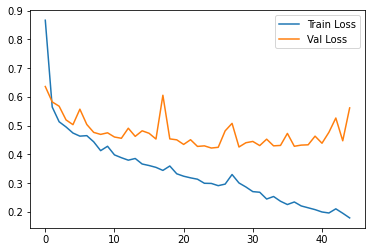

In [7]:
# visualizing losses and accuracy
# print(history.history)
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
xc         = range(45)

plt.figure()
plt.plot(xc, train_loss,label = 'Train Loss')
plt.plot(xc, val_loss,label = 'Val Loss')
plt.legend(loc='upper right')

In [1]:
_, acc = model.evaluate(test_dataset)
print(acc *100)

NameError: name 'model' is not defined

Prediction

<PIL.Image.Image image mode=L size=32x32 at 0x2930FEE80>
[[1.]]


2022-06-09 19:45:54.113983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


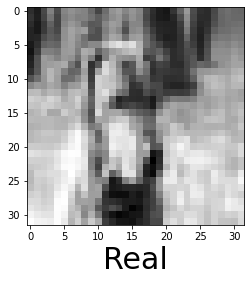

In [ ]:

def predictImage(filename):
    img1 = image.load_img(filename,target_size=(32,32),color_mode = "grayscale")
    print(img1)
    plt.imshow(img1,cmap='gray')
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        
        plt.xlabel("Real",fontsize=30)
        
    
    elif val == 0:
        
        plt.xlabel("Fake",fontsize=30)

predictImage(r"/Users/nayansavaliya/Masters Mechatronics/2022 Summer/RAML - Project/data/bicubic/test/imagewoof_test/985.jpg")


<PIL.Image.Image image mode=L size=32x32 at 0x148020C10>
[[1.]]


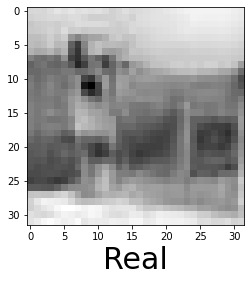

In [ ]:

predictImage(r"/Users/nayansavaliya/Masters Mechatronics/2022 Summer/RAML - Project/data/bicubic/test/SNGAN_bicubic_test/952.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[4.0000014e+00 6.8000000e+01 3.9999990e+00]
  [2.9216952e+00 4.4882446e+01 2.9216945e+00]
  [1.5521972e-01 1.3987633e+02 1.5520771e-01]
  ...
  [2.1741192e+00 6.8379547e+01 2.1741168e+00]
  [1.5521471e-01 1.3987622e+02 1.5520899e-01]
  [2.9216321e+00 4.4881618e+01 2.9216340e+00]]

 [[3.0157830e-06 6.3000000e+01 0.0000000e+00]
  [2.8610229e-06 8.9535538e+01 2.1324806e-06]
  [4.7683711e-06 9.3664864e+01 3.0157830e-06]
  ...
  [8.5299225e-06 1.4154083e+02 1.9073486e-06]
  [0.0000000e+00 9.3665169e+01 2.1324806e-06]
  [3.4385216e-06 8.9535606e+01 2.6973985e-06]]

 [[0.0000000e+00 6.0000000e+00 2.6656008e-07]
  [4.7683716e-07 8.2279663e+01 1.3486992e-06]
  [6.0315656e-06 1.4598997e+02 0.0000000e+00]
  ...
  [3.8146973e-06 2.4196512e+02 0.0000000e+00]
  [4.2649613e-06 1.4599020e+02 4.2649613e-06]
  [1.4305115e-06 8.2280121e+01 4.7683716e-07]]

 ...

 [[7.2111020e+00 1.7000000e+01 7.2111025e+00]
  [9.1003647e+00 1.6369589e+02 9.6414709e+00]
  [1.2369176e+01 1.8255197e+02 1.156908

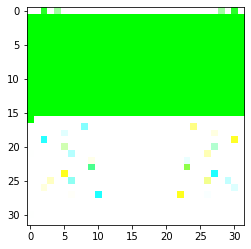

In [9]:
class PowerSpectrum(object):
    def __init__(self,image_size=None,scale=1):
        self.image_size = image_size
        self.scale = scale
        if self.image_size is not None:
            self.az_mask=self.build_azimuthal_mask()
        
    def power2D(self,x):
        x = tf.signal.fft2d(tf.cast(x,dtype=tf.complex64))
        x = tf.signal.fftshift(x, axes=None, name=None)
        return abs(x)
     
    def build_azimuthal_mask(self):
        
        x,y = np.meshgrid(np.arange(self.image_size),np.arange(self.image_size))
        R = np.sqrt((x-self.image_size/2)**2+(y-self.image_size/2)**2)
        masks = np.array(list(map(lambda r : (R >= r-.5) & (R < r+.5),np.arange(1,int(self.image_size/2+1),1))))
        norm = np.sum(masks,axis=(1,2),keepdims=True)
        masks=masks/norm
        n=len(masks)
        return tf.reshape(tf.cast(masks,dtype=tf.float32),(1,n,self.image_size,self.image_size))
        
    def az_average(self,x):
        x=tf.reshape(x,(-1,1,self.image_size,self.image_size))
        return tf.reduce_sum(tf.reduce_sum(tf.multiply(self.az_mask,x),axis=3),axis=2)
    
    def power1D(self,x):
        x = self.power2D(x)
        az_avg = self.az_average(x)
        ell=np.arange(int(az_avg.shape[1]))*9
        return tf.multiply(az_avg,tf.reshape(tf.cast(ell*(ell+1)/2/np.pi,dtype=tf.float32),(1,-1)))

ss = PowerSpectrum(image_size=32).power2D(image.load_img(r"/Users/nayansavaliya/Masters Mechatronics/2022 Summer/RAML - Project/data/bicubic/test/imagewoof_test/856.jpg",target_size=(32,32),color_mode = "rgb"))
print(ss)
plt.imshow(ss,cmap='gray')



tf.Tensor(
[[     0.    84156.35 224446.02 270031.8  260740.72 475722.56 598830.75
  639740.1  697710.06 810709.2  664137.25 769665.94 836384.75 716103.44
  729603.06 758634.1 ]], shape=(1, 16), dtype=float32)


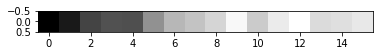

In [ ]:
ss1 = PowerSpectrum(image_size=32).power1D(image.load_img(r"/Users/nayansavaliya/Masters Mechatronics/2022 Summer/RAML - Project/data/bicubic/test/SNGAN_bicubic_test/840.jpg",target_size=(32,32),color_mode = "grayscale"))

print(ss1)
plt.imshow(ss1,cmap='gray')
